In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
__file__ = os.path.abspath('')
dir_path = '/'.join(os.path.realpath(__file__).split('/')[:-1])
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')
# sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

import sglm
import sglm_cv
import sglm_pp
import sglm_ez
import sglm_plt as splt

In [3]:
# import sys
# print(sys.path)

In [4]:
import pandas as pd



# filename = 'dlight_only_WT35_12212020.csv'
filename = 'dlight_only_WT36_12212020.csv'
# filename = 'Ach_only_WT53L_09032021xlsx.csv'
# filename = 'Ach_only_WT60R_10042021xlsx.csv'

df = pd.read_csv(f'../{filename}')


df = df[[_ for _ in df.columns if 'Unnamed' not in _]]

# .drop('Unnamed: 16', axis=1).drop('Unnamed: 17', axis=1) # .drop('index', axis=1)

print(df.columns)

df = df.rename({'center port occupancy': 'cpo',
                'center port entry': 'cpn',
                'center port exit': 'cpx',

                'left port occupancy': 'lpo',
                'left port entry': 'lpn',
                'left port exit': 'lpx',
                'left licks': 'll',

                'right port occupancy': 'rpo',
                'right port entry': 'rpn',
                'right port exit': 'rpx',
                'right licks': 'rl',

                'no reward': 'nr',
                'reward': 'r',

                'dF/F green (Ach3.0)': 'gdFF',
                'zscored green (Ach3.0)': 'zsgdFF',

                'dF/F green (dLight1.1)': 'gdFF',
                'zscored green (dLight1.1)': 'zsgdFF'
                }, axis=1)

# df['event_col_a'] = ((df['cpn'] > 0)*1).replace(0, np.nan) * 1.0
# df['event_col_b'] = df['nr'].replace(0, np.nan) * 2.0
# df['event_col_c'] = df['r'].replace(0, np.nan) * 3.0

# df['event_col'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])

# df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

# df['event_col'] = df['event_col'].bfill()
# df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']).shift(-10) * 1.0

# df['nTrial'] = df['trial_start_flag'].cumsum().ffill()


Index(['time (msec)', 'center port entry', 'center port occupancy',
       'center port exit', 'left port entry', 'left port occupancy',
       'left port exit', 'left licks', 'right port entry',
       'right port occupancy', 'right port exit', 'right licks', 'no reward',
       'reward', 'dF/F green (dLight1.1)', 'zscored green (dLight1.1)'],
      dtype='object')


In [5]:
# plt.plot(df[['event_col']].iloc[11000:12000])

In [6]:
# df[['event_col', 'trial_start_flag', 'nTrial', 'nEndTrial']].iloc[4000:5000].plot()
# plt.grid()

In [7]:
import numpy as np

trial_shift_bounds = 7

df['event_col_a'] = ((df['cpn'] > 0)*1).replace(0, np.nan) * 1.0
df['event_col_b'] = (df['nr']).replace(0, np.nan) * 2.0
df['event_col_c'] = (df['r']).replace(0, np.nan) * 3.0
df['event_col_d'] = ((df['lpx'] > 0)*1.0).replace(0, np.nan) * 1.0
df['event_col_e'] = ((df['rpx'] > 0)*1.0).replace(0, np.nan) * 1.0

df['event_col_start'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])

# df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

df['event_col_start'] = df['event_col_start'].bfill()
df['trial_start_flag'] = ((df['event_col_start'] == 1.0)&(df['event_col_start'].shift(-1) != df['event_col_start']) * 1.0).shift(-trial_shift_bounds) * 1.0
df['nTrial'] = df['trial_start_flag'].cumsum()

df['event_col_end'] = df['event_col_d'].combine_first(df['event_col_e']).combine_first(df['trial_start_flag'].replace(0.0, np.nan)*2.0)
df['event_col_end'] = df['event_col_end'].ffill()
# df['trial_end_flag'] = ((df['event_col_start'] != 1.0)&(df['event_col_start'].shift(-1) == 1.0)&(df['event_col_start'].shift(-1) != df['event_col_start']) * 1.0).shift(5) * 1.0
df['trial_end_flag'] = ((df['event_col_end'] == 1.0)&(df['event_col_end'].shift(1) == 2.0)&(df['event_col_end'].shift(1) != df['event_col_end'])&(df['nTrial'] > 0) * 1.0).shift(trial_shift_bounds) * 1.0
df['nEndTrial'] = df['trial_end_flag'].cumsum()


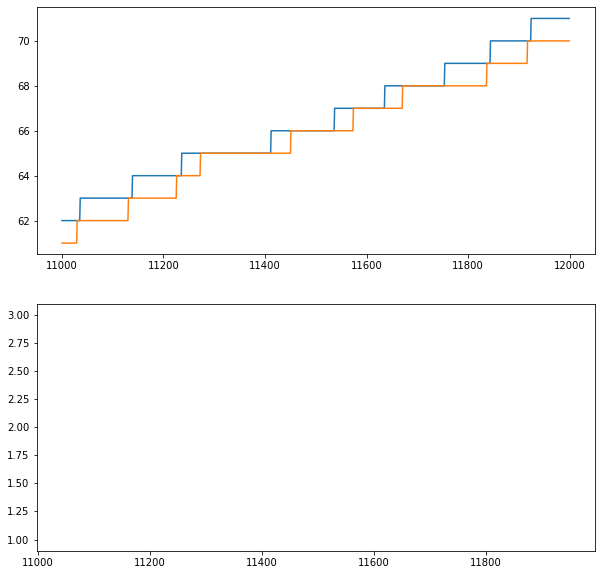

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(df[['nTrial', 'nEndTrial']].iloc[11000:12000])
ax[1].plot(df[['event_col_a', 'event_col_b', 'event_col_c']].iloc[11000:12000])

In [9]:
# df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']) * 1.0
# df

In [10]:

# Identify rewarded vs. unrewarded trials
df['r_trial'] = df.groupby('nTrial')['r'].transform(np.sum)
df['nr_trial'] = df.groupby('nTrial')['nr'].transform(np.sum)

# Identify combined reward vs. non-rewarded / left vs. right / entries vs. exits
df = df.assign(**{
    'rpxr':df['r_trial']*df['rpx'],
    'rpxnr':df['nr_trial']*df['rpx'],
    'lpxr':df['r_trial']*df['lpx'],
    'lpxnr':df['nr_trial']*df['lpx'],

    'rpnr':df['r_trial']*df['rpn'],
    'rpnnr':df['nr_trial']*df['rpn'],
    'lpnr':df['r_trial']*df['lpn'],
    'lpnnr':df['nr_trial']*df['lpn'],

})


In [11]:
# y_setup_col = 'rdFF' # photometry response
# df = sglm_ez.diff_cols(df, ['rdFF'])

# df['wi_trial_flag'] = (df['nTrial'] != df['nEndTrial'])&(~df['nTrial'].isna())&(~df['nEndTrial'].isna())

df['wi_trial_flag'] = (df['nTrial'] != df['nEndTrial'])&(~df['nTrial'].isna())&(~df['nEndTrial'].isna())

X_cols = [
    'nTrial',
    # 'nEndTrial',
    # 'wi_trial_flag',
    #'cpo',
    'cpn', 'cpx',
    #'lpo',
    
    
    'lpn', 'rpn',
    # 'rpnr', 'rpnnr',
    # 'lpnr', 'lpnnr',

    #'rpo',
    'lpx', 'rpx',
    'll', 'rl',
    # 'nr', 'r'

    # 'trial_start_flag', 'trial_end_flag',
]

ignore_cols = ['nEndTrial', 'r', 'nr', 'wi_trial_flag', 'r_trial', 'nr_trial']#, 'rpn', 'lpn']

# y_col = 'gdFF'
y_col = 'zsgdFF'
# y_col = 'grnR'

eps = 1e-6

dfrel = df[X_cols + ignore_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1


dfrel = dfrel[dfrel[y_col].abs() > eps]




# ##### TODO: VALIDATE THE NN / XX APPROACH HERE
# dfrel['nn'] = dfrel[['lpn', 'rpn']].sum(axis=1)
# dfrel['xx'] = dfrel[['lpx', 'rpx']].sum(axis=1)

# first_trans = dfrel.groupby('nTrial')[['nn', 'xx', 'lpn', 'rpn', 'lpx', 'rpx']].cumsum()
# first_trans = ((first_trans == 1)*1).diff()
# first_trans *= first_trans >= 0
# first_trans[['lpn', 'rpn']] = (first_trans[['lpn', 'rpn']].values == first_trans[['nn']].values)*(first_trans[['lpn', 'rpn']].values)*1.0
# first_trans[['lpx', 'rpx']] = (first_trans[['lpx', 'rpx']].values == first_trans[['xx']].values)*(first_trans[['lpx', 'rpx']].values)*1.0
# first_trans = first_trans.rename({_k:f'ft_{_k}' for _k in first_trans.columns}, axis=1)
# dfrel[first_trans.columns] = first_trans
# # dfrel.iloc[5000:6000].plot()



dfrel['wi_trial_flag'] = dfrel['wi_trial_flag'].astype(bool)

print(dfrel)
print(X_cols)

neg_order = -10
pos_order = 10

       nTrial  cpn  cpx  lpn  rpn  lpx  rpx   ll   rl  nEndTrial    r   nr  \
150       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0  0.0  0.0   
151       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0        0.0  0.0  0.0   
152       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0  0.0  0.0   
153       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0        0.0  0.0  0.0   
154       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0  0.0  0.0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...        ...  ...  ...   
34444   250.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      250.0  0.0  0.0   
34445   250.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      250.0  0.0  0.0   
34446   250.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      250.0  0.0  0.0   
34447   250.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      250.0  0.0  0.0   
34448   250.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      250.0  0.0  0.0   

       wi_trial_flag  r_trial  nr_trial    zsgdFF  
150        

In [12]:

##### TODO: VALIDATE THE NN / XX APPROACH HERE
dfrel['nn'] = dfrel[['lpn', 'rpn']].sum(axis=1)
dfrel['xx'] = dfrel[['lpx', 'rpx']].sum(axis=1)

first_trans = dfrel.groupby('nTrial')[['nn', 'xx', 'lpn', 'rpn', 'lpx', 'rpx', 'cpn', 'cpx']].cumsum()
first_trans = ((first_trans == 1)*1).diff()
first_trans *= first_trans >= 0
# first_trans[['lpn', 'rpn']] = (first_trans[['lpn', 'rpn']].values == first_trans[['nn']].values)*(first_trans[['lpn', 'rpn']].values)*1.0
# first_trans[['lpx', 'rpx']] = (first_trans[['lpx', 'rpx']].values == first_trans[['xx']].values)*(first_trans[['lpx', 'rpx']].values)*1.0

first_trans['lpn'] = dfrel['nn']*dfrel['lpn']
first_trans['rpn'] = dfrel['nn']*dfrel['rpn']
first_trans['lpx'] = dfrel['xx']*dfrel['lpx']
first_trans['rpx'] = dfrel['xx']*dfrel['rpx']

first_trans = first_trans.rename({_k:f'ft_{_k}' for _k in first_trans.columns}, axis=1)
dfrel[first_trans.columns] = first_trans
# dfrel.iloc[5000:6000].plot()



In [13]:
# Identify combined reward vs. non-rewarded / left vs. right / entries vs. exits
dfrel = dfrel.assign(**{
    'ft_rpnr':dfrel['r_trial']*dfrel['ft_rpn'],
    'ft_rpnnr':dfrel['nr_trial']*dfrel['ft_rpn'],
    'ft_lpnr':dfrel['r_trial']*dfrel['ft_lpn'],
    'ft_lpnnr':dfrel['nr_trial']*dfrel['ft_lpn'],

})

In [14]:
# dfrel['strat_id'] = dfrel['ft_lpn']*dfrel['r'] + 10*
tmpdf = dfrel[['nTrial', 'ft_rpnr', 'ft_rpnnr', 'ft_lpnr', 'ft_lpnnr']].assign(nTrial2=dfrel['nTrial']-dfrel['nEndTrial'])
a = (tmpdf[tmpdf['nTrial2'] != 0].groupby(['nTrial', 'nTrial2']).transform(np.max) > 0)*1.0
# a.iloc[5000:11000].plot(alpha=0.5)
a = a.replace(0, np.nan)
b = (a.iloc[:,0]*1.0).combine_first(a.iloc[:,1]*2.0).combine_first(a.iloc[:,2]*3.0).combine_first(a.iloc[:,3]*4.0).fillna(0.0)
dfrel['strat_id'] = b
# dfrel['strat_id'] = dfrel['strat_id'].ffill()
# tmpdf

In [15]:

# dfrel['nn'] = dfrel[['lpn', 'rpn']].sum(axis=1)
# dfrel['xx'] = dfrel[['lpx', 'rpx']].sum(axis=1)
# first_trans = dfrel.groupby('nTrial')[['nn', 'lpn', 'rpn', 'lpx', 'rpx']].cumsum()
# first_trans = ((first_trans == 1)*1).diff()
# first_trans *= first_trans >= 0
# first_trans[['lpn', 'rpn']] = (first_trans[['lpn', 'rpn']] == first_trans['nn'])*(first_trans[['lpn', 'rpn']])*1.0
# first_trans = first_trans.rename({_k:f'ft_{_k}' for _k in first_trans.columns}, axis=1)

# first_trans[['lpn', 'rpn']].values == first_trans[['nn']].values

<AxesSubplot:>

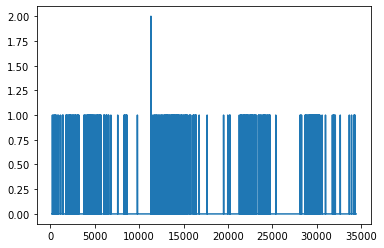

In [16]:
dfrel['lpn'].plot()

In [17]:
# dfrel = dfrel.copy()
# dfrel['wi_trial_flag'] = dfrel['wi_trial_flag'].astype(bool)
# # dfrel = dfrel[dfrel['nTrial'] > 0]
# dfrel = dfrel.dropna()
# dfrel.drop('zsgdFF', axis=1).to_csv('lynne_for_tensor_regression_X.csv')
# dfrel['zsgdFF'].to_csv('lynne_for_tensor_regression_y.csv')
# (dfrel.isna().sum(axis=1)*1).plot()


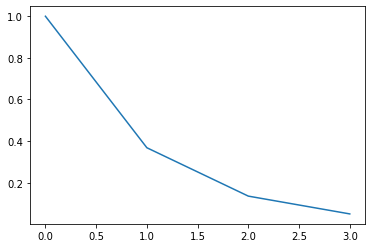

In [18]:
plt.plot(np.exp(-np.arange(4)))

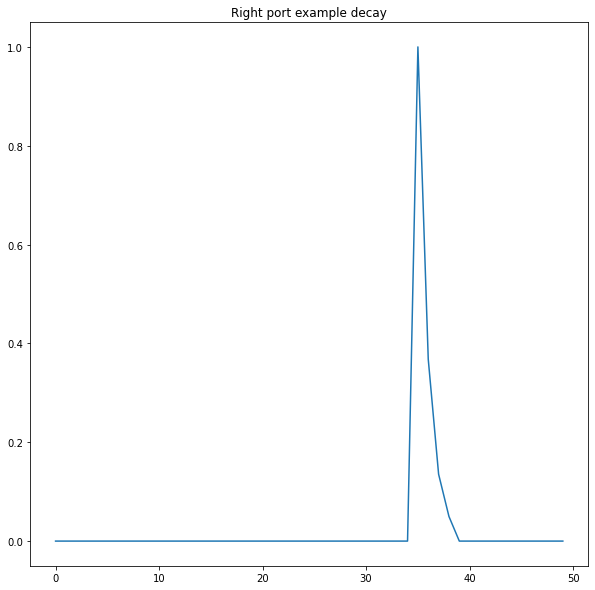

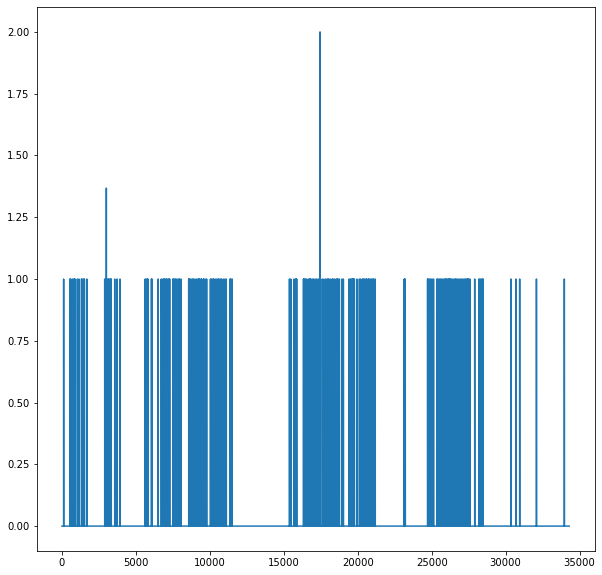

In [19]:
exp_decay_delta_rt = np.convolve(dfrel['rpn'], np.exp(-np.arange(4)), mode='full')[:len(dfrel)]
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_rt[80:130])
plt.title('Right port example decay')
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_rt)

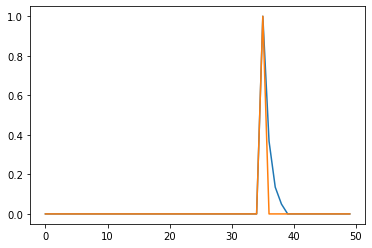

In [20]:
timeshift_sanity_check = np.convolve(dfrel['rpn'], np.exp(-np.arange(4)), mode='full')
plt.plot(timeshift_sanity_check[80:130])
plt.plot(dfrel['rpn'].values[80:130])


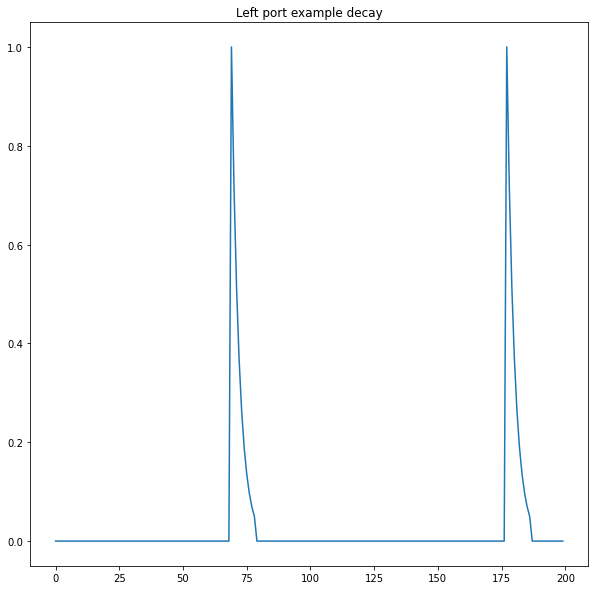

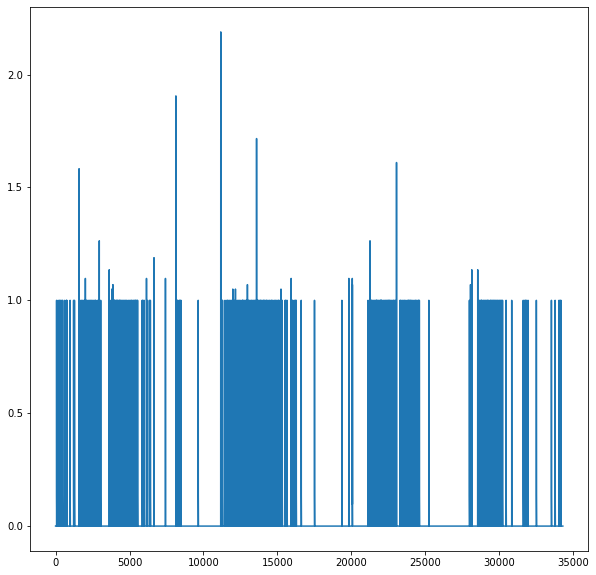

In [21]:
exp_decay_delta_lft = np.convolve(dfrel['lpn'], np.exp(-np.arange(10)/3), mode='full')[:len(dfrel)]
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_lft[0:200])
plt.title('Left port example decay')
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_lft)

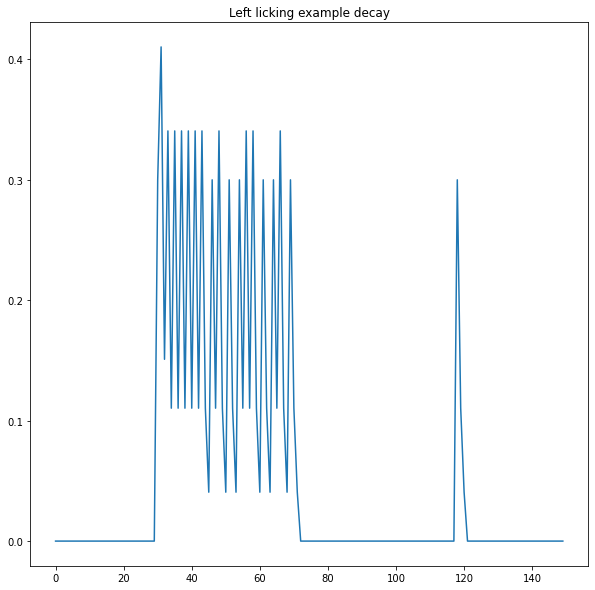

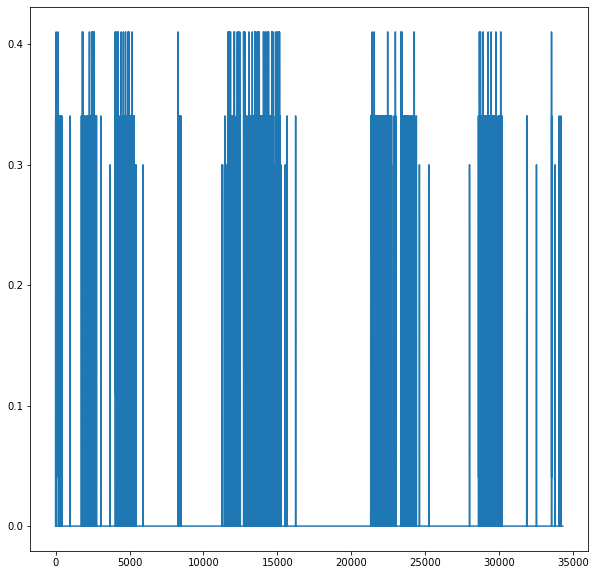

In [22]:
exp_decay_delta_ll = np.convolve(dfrel['ll'], 0.3*np.exp(-np.arange(3)), mode='full')[:len(dfrel)]
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_ll[150:300])
plt.title('Left licking example decay')
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_ll)

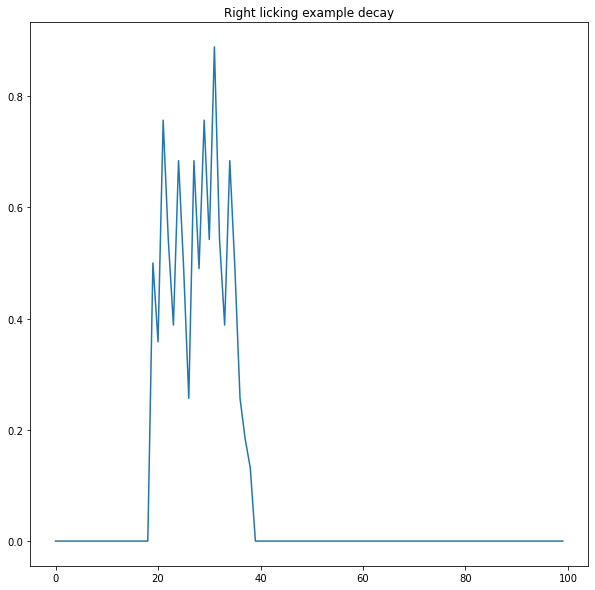

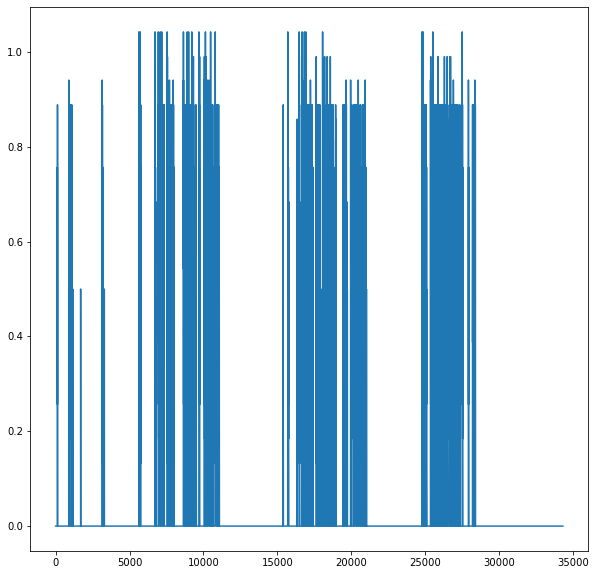

In [23]:
exp_decay_delta_rl = np.convolve(dfrel['rl'], 0.5*np.exp(-np.arange(5)/3), mode='full')[:len(dfrel)]
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_rl[100:200])
plt.title('Right licking example decay')
plt.figure(figsize=(10,10))
plt.plot(exp_decay_delta_rl)

In [24]:
noise = np.random.normal(0, 0.1, len(dfrel))

In [25]:
### REPLACE FOR TOY DATA
# dfrel['zsgdFF'] = exp_decay_delta_rt + exp_decay_delta_lft + exp_decay_delta_ll + exp_decay_delta_rl + noise

In [26]:
dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[1:], neg_order=neg_order, pos_order=pos_order)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[1:], neg_order=neg_order, pos_order=pos_order)

# X_cols_sftd = ['nTrial', 'nEndTrial']+[_ for _ in X_cols_sftd if '_-10' in _ or '_-9' in _ or '_-8' in _ or '_-7' in _ or '_-6' in _] #or '_-5' in _]


dfrel = dfrel.dropna()
X_setup = dfrel.copy()
y_setup = dfrel[y_col].copy()

In [27]:
df['nTrial']

0          0
1          0
2          0
3          0
4          0
        ... 
36994    NaN
36995    NaN
36996    NaN
36997    NaN
36998    NaN
Name: nTrial, Length: 36999, dtype: object

In [28]:
# holdout = sglm_ez.holdout_split_by_trial_id(X_setup, y_setup, id_cols=['nTrial'], strat_col='strat_id', strat_mode='balanced_train', perc_holdout=0.2)
holdout = sglm_ez.holdout_split_by_trial_id(X_setup, y_setup, id_cols=['nTrial'], strat_col='strat_id', strat_mode='stratify', perc_holdout=0.2)



In [29]:
# holdout = sglm_ez.holdout_split_by_trial_id(X_setup, y_setup, id_cols=['nTrial'], perc_holdout=0.05)
# holdout = sglm_ez.holdout_split_by_trial_id(X_setup, y_setup, id_cols=['nTrial'], strat_col='strat_id', strat_mode='balanced_train', perc_holdout=0.2)

X_tr = X_setup[~holdout]
y_tr = y_setup[~holdout]

X_te = X_setup[holdout]
y_te = y_setup[holdout]

# tr_keep = (X_tr['nTrial'] != X_tr['nEndTrial'])
# te_keep = (X_te['nTrial'] != X_te['nEndTrial'])

# X_tr = X_tr[tr_keep][X_cols_sftd]
# y_tr = y_tr[tr_keep]
# X_te = X_te[te_keep][X_cols_sftd]
# y_te = y_te[te_keep]


X_tr = X_tr[X_cols_sftd]
y_tr = y_tr
X_te = X_te[X_cols_sftd]
y_te = y_te

best_params = {'max_iter': 1000, 'alpha': 0.01, 'l1_ratio': 0.0, 'fit_intercept': True}
# best_params = {'max_iter': 1000, 'alpha': 0.0, 'l1_ratio': 0.0, 'fit_intercept': True}
# best_params = {'max_iter': 1000, 'alpha': 0.0, 'l1_ratio': 0.0, 'fit_intercept': True}

In [30]:
glm = sglm_ez.fit_GLM(X_tr[X_cols_sftd], y_tr, **best_params)


In [31]:
# for ic,c in enumerate(glm.coef_):
#     print(ic, X_cols_sftd[ic], c)



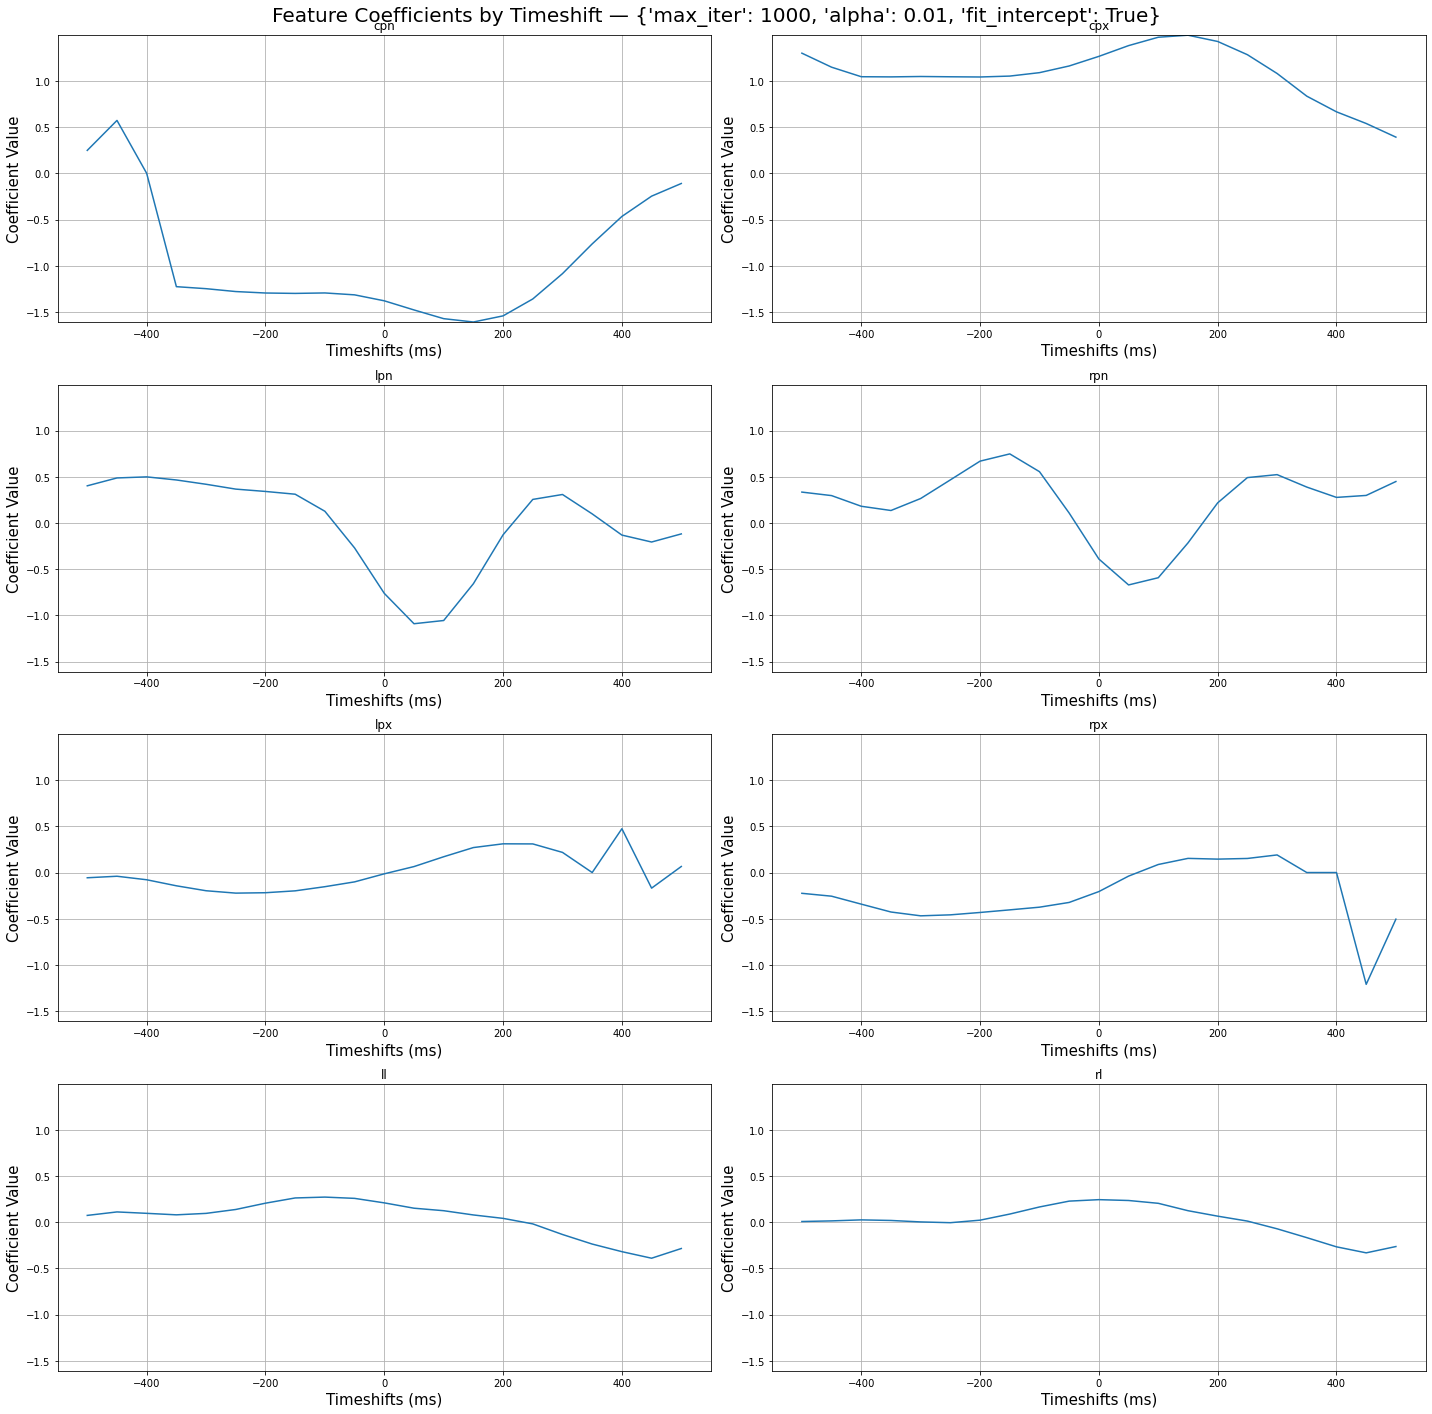

In [32]:
splt.plot_all_beta_coefs(glm, X_cols, X_cols_sftd, plot_width=2, plot_name=str(glm.kwargs), binsize=50, filename='figure_outputs/beta_coeffs.png')

In [33]:
X_cols_sftd[np.argmax(glm.coef_)+2]

'rpn_3'

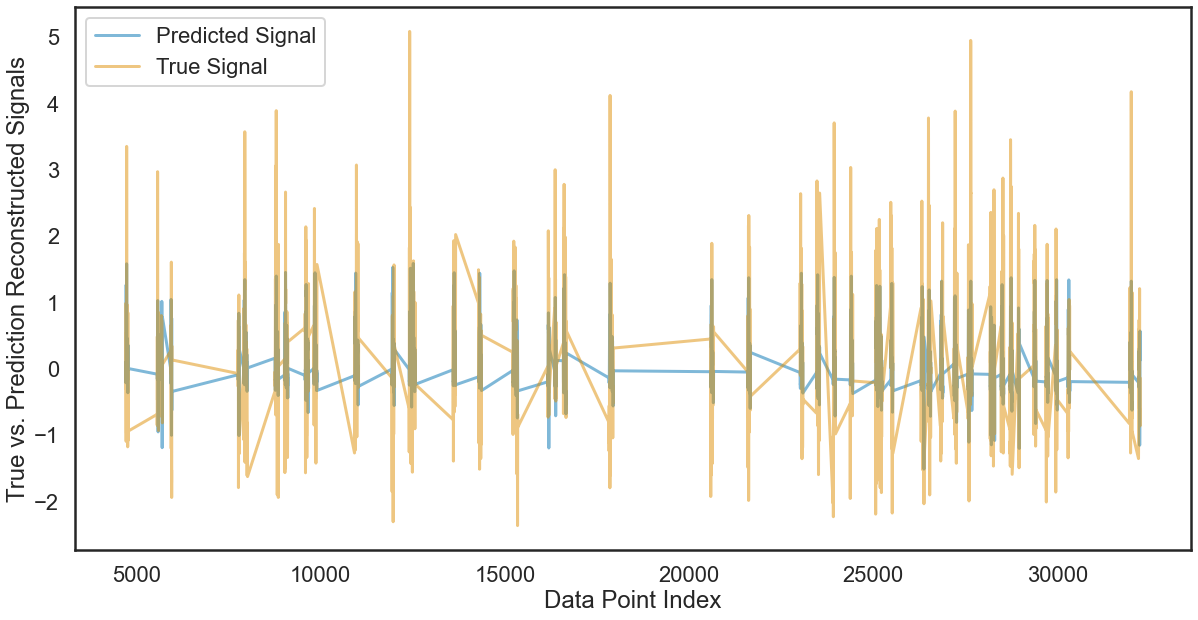

In [34]:
_ = splt.reconstruct_signal(glm, X_te, y_te)

In [35]:
tmp = dfrel[holdout]
tmp = tmp[(tmp['nTrial'] != tmp['nEndTrial'])].copy()
tmp['1'] = 1
tmp['tim'] = tmp.groupby('nTrial')['1'].cumsum()
tmp['pred'] = glm.predict(tmp[X_cols_sftd])

entry_timing_r = tmp.groupby('nTrial')['rpn'].transform(lambda x: x.argmax()).astype(int)
entry_timing_l = tmp.groupby('nTrial')['lpn'].transform(lambda x: x.argmax()).astype(int)
entry_timing = (entry_timing_r > entry_timing_l)*entry_timing_r + (entry_timing_r < entry_timing_l)*entry_timing_l

adjusted_time = (tmp['tim'] - entry_timing)
print(adjusted_time)
tmp['adjusted_time'] = adjusted_time
adjusted_time.index = tmp.index


entry_timing_c = tmp.groupby('nTrial')['ft_cpn'].transform(lambda x: x.argmax()).astype(int)
adjusted_time_c = (tmp['tim'] - entry_timing_c)
adjusted_time_c.index = tmp.index
tmp['cpn_adjusted_time'] = adjusted_time_c


4701    -23
4702    -22
4703    -21
4704    -20
4705    -19
         ..
32240     9
32241    10
32242    11
32243    12
32244    13
Length: 3403, dtype: int64


In [36]:
tmp_backup = tmp.copy()

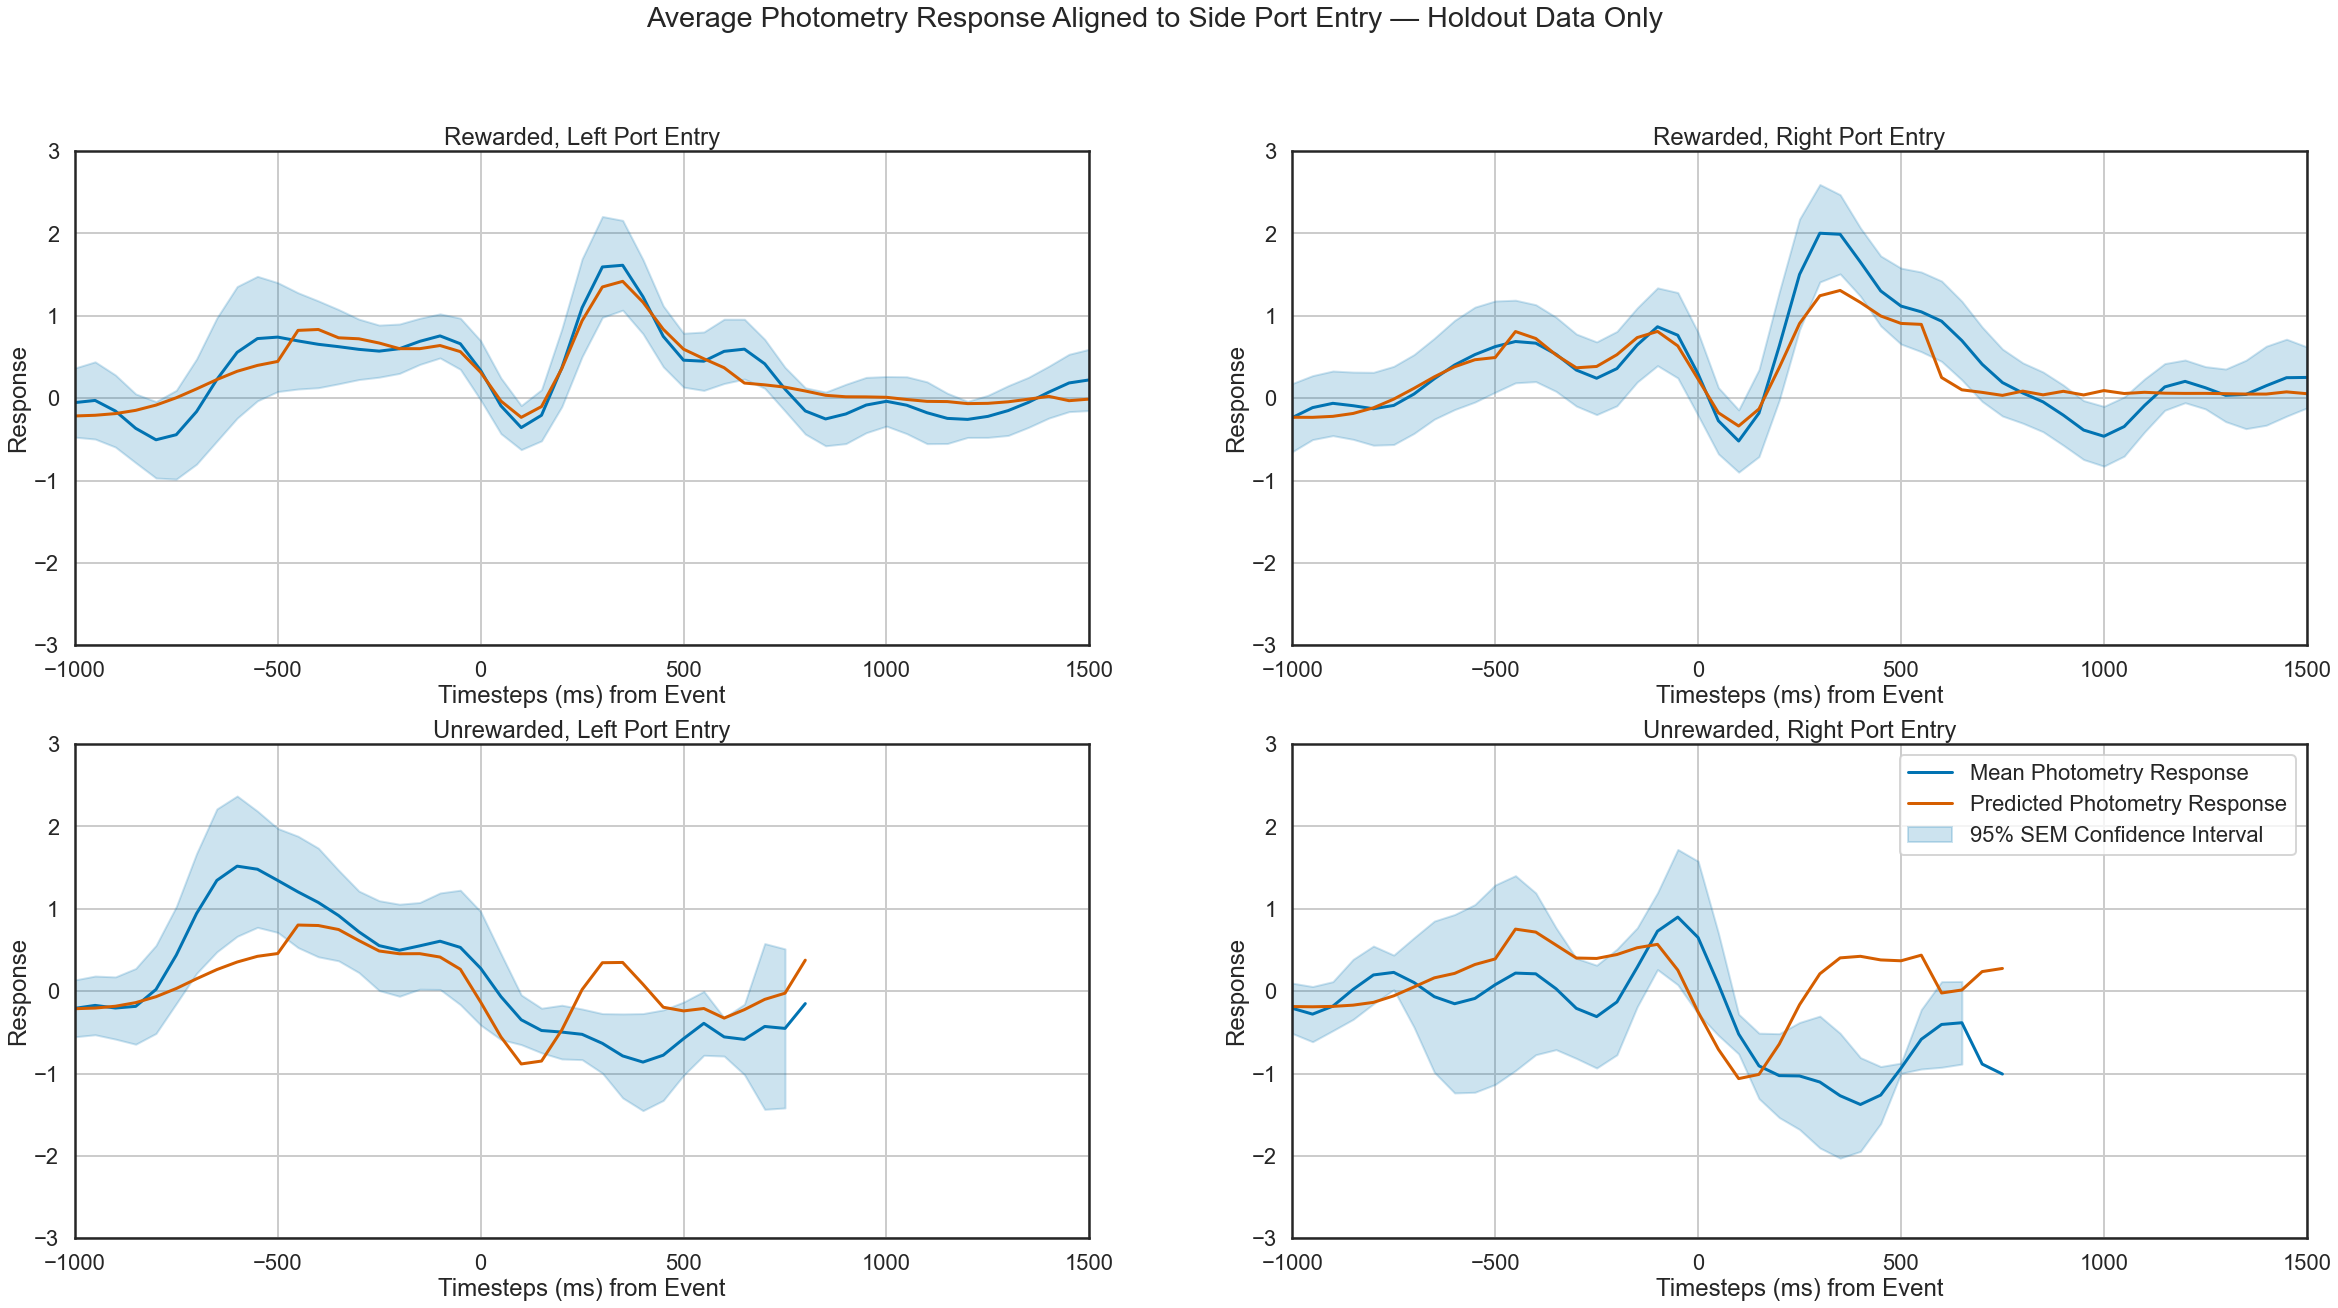

In [37]:
binsize = 50

min_time = -20
max_time = 30
min_signal = -3.0
max_signal = 3.0

x_label = 'Timesteps __ from Event'
y_label = 'Response'

if binsize is not None:
    min_time *= binsize
    max_time *= binsize
    x_label = x_label.replace(' __', ' (ms)')
    tmp_backup['plot_time'] = tmp_backup['adjusted_time'] * binsize
else:
    x_label = x_label.replace(' __', '')
    tmp_backup['plot_time'] = tmp_backup['adjusted_time']



tmp = tmp_backup[tmp_backup['plot_time'].between(min_time, max_time)].copy()


# plt.figure(figsize=(10,5))
fig, ax = plt.subplots(2,2)
fig.suptitle('Average Photometry Response Aligned to Side Port Entry — Holdout Data Only')
fig.set_figheight(20)
fig.set_figwidth(40)

tmp['is_r_lpn_trial'] = sglm_ez.get_is_trial(tmp, ['nTrial'], ['r', 'ft_lpn'])
tmp['is_r_rpn_trial'] = sglm_ez.get_is_trial(tmp, ['nTrial'], ['r', 'ft_rpn'])
tmp['is_nr_lpn_trial'] = sglm_ez.get_is_trial(tmp, ['nTrial'], ['nr', 'ft_lpn'])
tmp['is_nr_rpn_trial'] = sglm_ez.get_is_trial(tmp, ['nTrial'], ['nr', 'ft_rpn'])

# rgb = tmp[tmp['is_rlpn_trial']].groupby(['plot_time'])['zsgdFF'].mean().plot()
ci_setup = sglm_ez.get_sem(tmp, tmp['is_r_lpn_trial'], 'plot_time', 'zsgdFF')
ax[0,0].plot(ci_setup['mean'], color='b')
ax[0,0].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = sglm_ez.get_sem(tmp, tmp['is_r_lpn_trial'], 'plot_time', 'pred')
ax[0,0].plot(ci_setup['mean'], color='r')


ax[0,0].set_xlim((min_time, max_time))
ax[0,0].set_ylim((min_signal, max_signal))
ax[0,0].title.set_text('Rewarded, Left Port Entry')
ax[0,0].set_xlabel(x_label)
ax[0,0].set_ylabel(y_label)
ax[0,0].grid()
# print(ci_setup.iloc[-1])

# # plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
# fig.set_figheight(5)
# fig.set_figwidth(10)
ci_setup = sglm_ez.get_sem(tmp, tmp['is_r_rpn_trial'], 'plot_time', 'zsgdFF')
ax[0,1].plot(ci_setup['mean'])
ax[0,1].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = sglm_ez.get_sem(tmp, tmp['is_r_rpn_trial'], 'plot_time', 'pred')
ax[0,1].plot(ci_setup['mean'], color='r')



ax[0,1].set_xlim((min_time, max_time))
ax[0,1].set_ylim((min_signal, max_signal))
ax[0,1].title.set_text('Rewarded, Right Port Entry')
ax[0,1].set_xlabel(x_label)
ax[0,1].set_ylabel(y_label)
ax[0,1].grid()
# print(ci_setup.iloc[-1])

# # plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
# fig.set_figheight(5)
# fig.set_figwidth(10)
ci_setup = sglm_ez.get_sem(tmp, tmp['is_nr_lpn_trial'], 'plot_time', 'zsgdFF')
ax[1,0].plot(ci_setup['mean'])
ax[1,0].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = sglm_ez.get_sem(tmp, tmp['is_nr_lpn_trial'], 'plot_time', 'pred')
ax[1,0].plot(ci_setup['mean'], color='r')



ax[1,0].set_xlim((min_time, max_time))
ax[1,0].set_ylim((min_signal, max_signal))
ax[1,0].title.set_text('Unrewarded, Left Port Entry')
ax[1,0].set_xlabel(x_label)
ax[1,0].set_ylabel(y_label)
ax[1,0].grid()
# print(ci_setup.iloc[-1])

# # plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
# fig.set_figheight(5)
# fig.set_figwidth(10)
ci_setup = sglm_ez.get_sem(tmp, tmp['is_nr_rpn_trial'], 'plot_time', 'zsgdFF')
ax[1,1].plot(ci_setup['mean'])
ax[1,1].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = sglm_ez.get_sem(tmp, tmp['is_nr_rpn_trial'], 'plot_time', 'pred')
ax[1,1].plot(ci_setup['mean'], color='r')



ax[1,1].set_xlim((min_time, max_time))
ax[1,1].set_ylim((min_signal, max_signal))
ax[1,1].title.set_text('Unrewarded, Right Port Entry')
ax[1,1].set_xlabel(x_label)
ax[1,1].set_ylabel(y_label)
ax[1,1].grid()
# print(ci_setup.iloc[-1])

ax[1,1].legend(['Mean Photometry Response',
                'Predicted Photometry Response',
                '95% SEM Confidence Interval'])


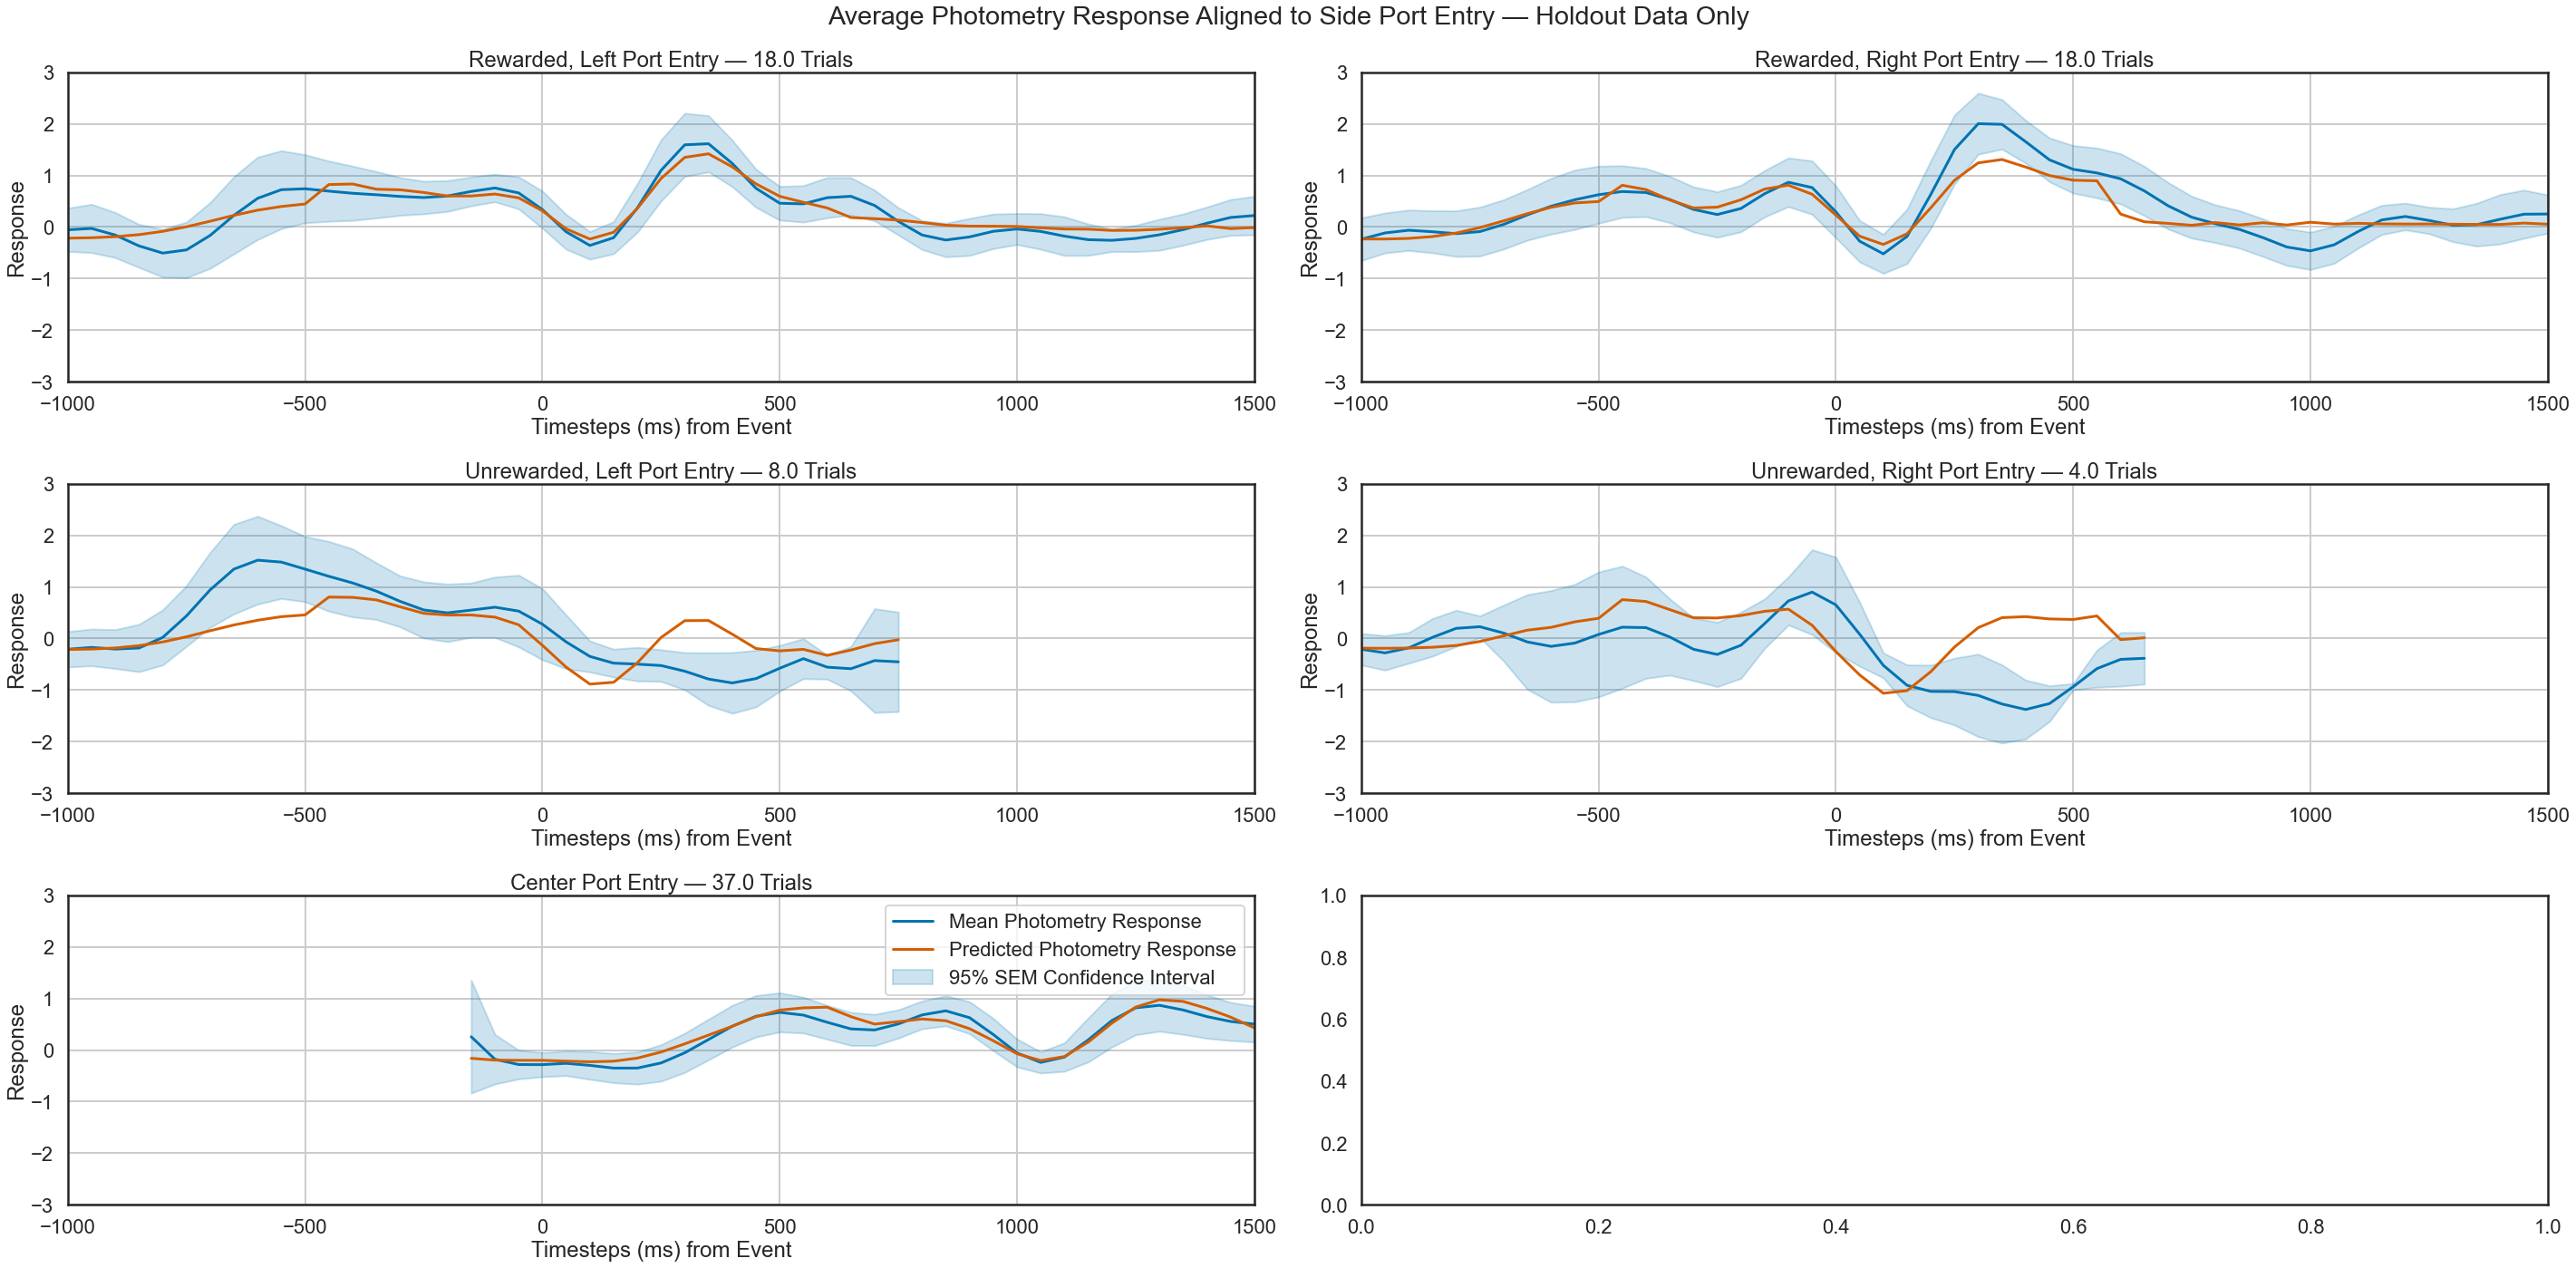

In [38]:
splt.plot_avg_reconstructions(tmp, 
                             plt_col_lst = [['r', 'lpn', 'Rewarded, Left Port Entry', 'adjusted_time'],
                                            ['r', 'rpn', 'Rewarded, Right Port Entry', 'adjusted_time'],
                                            ['nr', 'lpn', 'Unrewarded, Left Port Entry', 'adjusted_time'],
                                            ['nr', 'rpn', 'Unrewarded, Right Port Entry', 'adjusted_time'],
                                            ['cpn', 'Center Port Entry', 'cpn_adjusted_time']],
                                            binsize = 50, min_time = -20, max_time = 30, min_signal = -3.0, max_signal = 3.0)


In [39]:
# tmp[tmp['rpn']*tmp['r'] == 1]['zsgdFF']
# tmp[((tmp['lpn']*tmp['nr']).shift(20) == 1)&((tmp['nTrial']).shift(20) == tmp['nTrial'])]['zsgdFF'].agg([np.mean, np.std, np.min, np.max, lambda x: len(x)])
# tmp[((tmp['rpn']*tmp['nr']).shift(0) == 1)&((tmp['nTrial']).shift(0) == tmp['nTrial'])]['zsgdFF'].agg([np.mean, np.std, np.min, np.max, lambda x: len(x)])
len(tmp[((tmp['rpn']*tmp['nr']).shift(0) == 1)])


4

In [40]:
dfrel['nTrial'].nunique()

250

In [41]:
dfrel

,nTrial,cpn,cpx,lpn,rpn,lpx,rpx,ll,rl,nEndTrial,...,ll_9,rl_9,cpn_10,cpx_10,lpn_10,rpn_10,lpx_10,rpx_10,ll_10,rl_10
4154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4155,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4156,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4157,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4158,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33699,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33700,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33701,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33702,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
def df_photometry_avg(df, aligned_event, align_to='onset', window_length=[200,600]):
    
    pre_window, post_window = window_length
    
    import itertools

    if align_to=='onset':
        idx=df.loc[df[aligned_event]==1].groupby('nTrial').head(1).index.values # event alignment position per trial

    elif align_to=='offset':
        idx=df.loc[df[aligned_event]==1].groupby('nTrial').tail(1).index.values # event alignment position per trial

    d_ = df.copy()


    all_idx=[np.arange(i-pre_window, i+post_window) for i in idx] # idx list for each trial window
    all_idx = list(itertools.chain(*all_idx))  # flatten into list
    
    # print('d_', d_)
    # print('all_idx', all_idx)
    
    d_.loc[all_idx, 'i_idx'] = list(itertools.chain(*[np.arange(-pre_window*.005, post_window*.005, step=.005)]*len(idx)))
    
    return d_

In [43]:
tmp['ft_r_rpn'] = tmp['ft_rpn'] * tmp['r']
tmp['ft_r_lpn'] = tmp['ft_lpn'] * tmp['r']
tmp['ft_nr_rpn'] = tmp['ft_rpn'] * tmp['nr']
tmp['ft_nr_lpn'] = tmp['ft_lpn'] * tmp['nr']

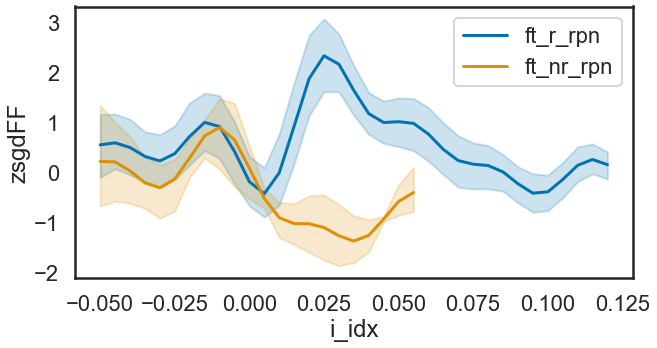

In [44]:
import seaborn as sns
# sns.lineplot(x='i_idx', y='zsgdFF', data=df_photometry_avg(tmp.reset_index(), 'ft_rpn', align_to='onset', window_length=[10,30]))
# sns.lineplot(x='i_idx', y='zsgdFF', data=df_photometry_avg(tmp.reset_index(), 'ft_lpn', align_to='onset', window_length=[10,30]))

plt.figure(figsize=(10,5))
sns.lineplot(x='i_idx', y='zsgdFF', data=df_photometry_avg(tmp.reset_index(), 'ft_r_rpn', align_to='onset', window_length=[10,25]))
sns.lineplot(x='i_idx', y='zsgdFF', data=df_photometry_avg(tmp.reset_index(), 'ft_nr_rpn', align_to='onset', window_length=[10,12]))

# sns.lineplot(x='i_idx', y='zsgdFF', data=df_photometry_avg(tmp.reset_index(), 'ft_rpn', align_to='onset', window_length=[10,10]))
plt.legend(['ft_r_rpn', 'ft_nr_rpn'])


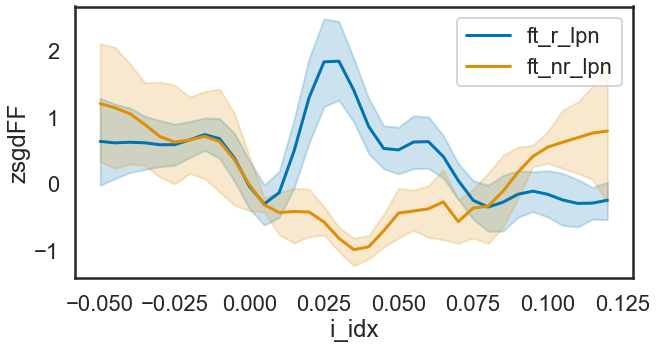

In [45]:
plt.figure(figsize=(10,5))
sns.lineplot(x='i_idx', y='zsgdFF', data=df_photometry_avg(tmp.reset_index(), 'ft_r_lpn', align_to='onset', window_length=[10,25]))
sns.lineplot(x='i_idx', y='zsgdFF', data=df_photometry_avg(tmp.reset_index(), 'ft_nr_lpn', align_to='onset', window_length=[10,25]))
plt.legend(['ft_r_lpn', 'ft_nr_lpn'])

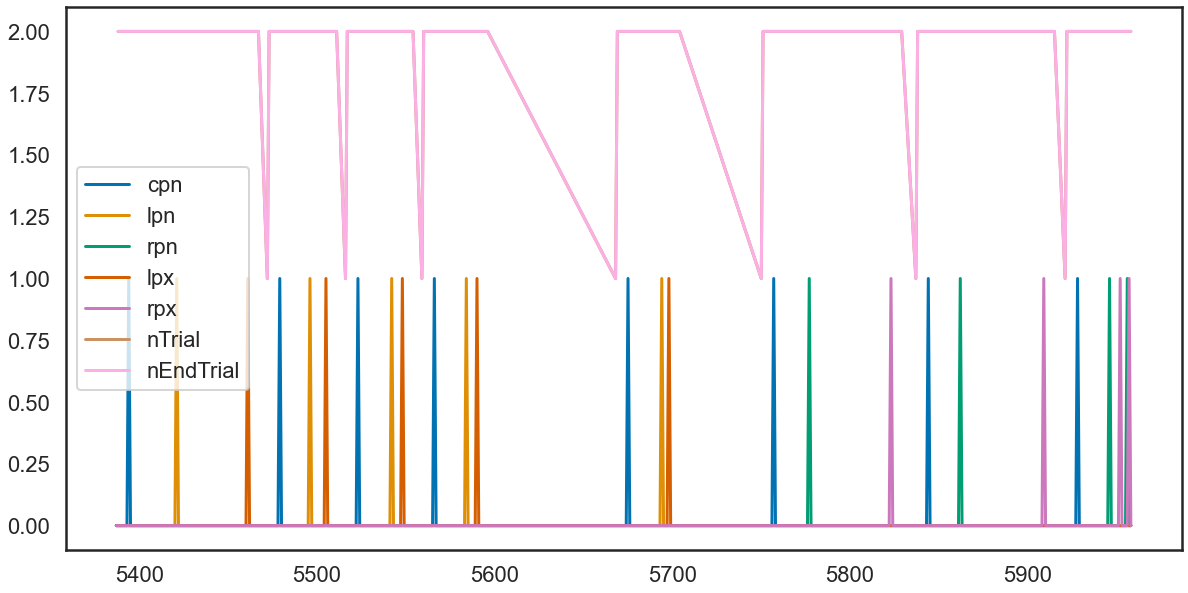

In [46]:
plt.figure(figsize=(20,10))
plt.plot(dfrel[dfrel['nTrial'].isin(list(range(15,23)))][['cpn', 'lpn', 'rpn', 'lpx', 'rpx']])
plt.plot(1 - dfrel[dfrel['nTrial'].isin(list(range(15,23)))][['nTrial', 'nEndTrial']].diff() + 1)

plt.legend(['cpn', 'lpn', 'rpn', 'lpx', 'rpx', 'nTrial', 'nEndTrial'])

In [47]:
# trial_val = ((dfrel['nTrial'] != dfrel['nEndTrial'])*1).diff()
# trial_val *= trial_val>0
# trial_val = trial_val.cumsum()
# (trial_val*1).iloc[4000:5000].plot()

In [48]:
# first_trans = dfrel.groupby('nTrial')[['lpn', 'rpn', 'lpx', 'rpx']].cumsum()
# first_trans = ((first_trans == 1)*1).diff()
# first_trans *= first_trans >= 0
# first_trans = first_trans.rename({_k:f'ft_{_k}' for _k in first_trans.columns}, axis=1)
# dfrel[first_trans.columns] = first_trans
# dfrel.iloc[5000:6000].plot()